In [1]:
%matplotlib inline
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp

In [2]:
survey_length = 0.3 # days
# Define what we want the final visit ratio map to look like
filtername = 'r'

target_map = fs.standard_goals()[filtername]

bfs = []
#bfs.append(fs.Depth_percentile_basis_function(filtername=filtername))
bfs.append(fs.M5_diff_basis_function(filtername=filtername, teff=False))
bfs.append(fs.Target_map_basis_function(target_map=target_map, filtername=filtername, out_of_bounds_val=hp.UNSEEN))
bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50.))
bfs.append(fs.Slewtime_basis_function(filtername=filtername))

weights = np.array([1, 0.2, 1., 2.])
survey = fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername)
scheduler = fs.Core_scheduler([survey])

In [3]:
observatory = Speed_observatory()
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='one_filter_testing.db',
                                                     delete_past=True)


/Users/yoachim/gitRepos/sims_ocs/python/lsst/sims/ocs/environment/seeing_model.py:61: RuntimeWarning: invalid value encountered in power
  airmass_correction = numpy.power(airmass, self.AIRMASS_CORRECTION_POWER)


progress = 97.8%Completed 670 observations


In [4]:
status = observatory.return_status()
r1 = status['lmst']*180/12
r2 = np.degrees(observatory.obs.lat)

/Users/yoachim/gitRepos/sims_ocs/python/lsst/sims/ocs/environment/seeing_model.py:61: RuntimeWarning: invalid value encountered in power
  airmass_correction = numpy.power(airmass, self.AIRMASS_CORRECTION_POWER)


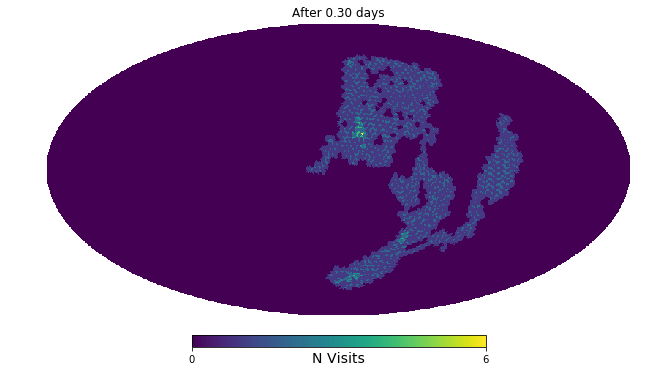

In [5]:

for survey in scheduler.surveys:
    hp.mollview(survey.basis_functions[1].survey_features['N_obs'].feature,  unit='N Visits', rot=(r1,r2), title='After %.2f days'%survey_length)

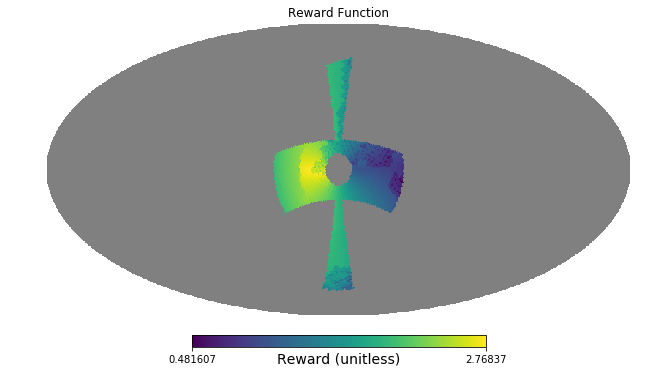

In [6]:
for survey in scheduler.surveys:
    hp.mollview(survey.reward, rot=(r1,r2), title='Reward Function', unit='Reward (unitless)')

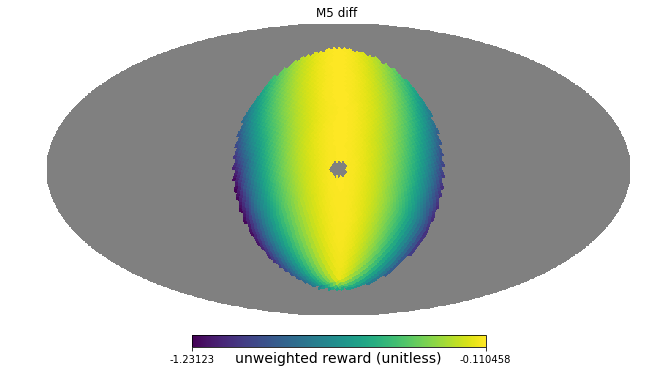

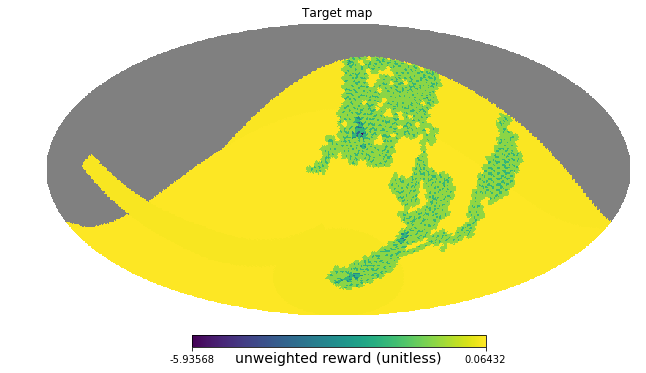

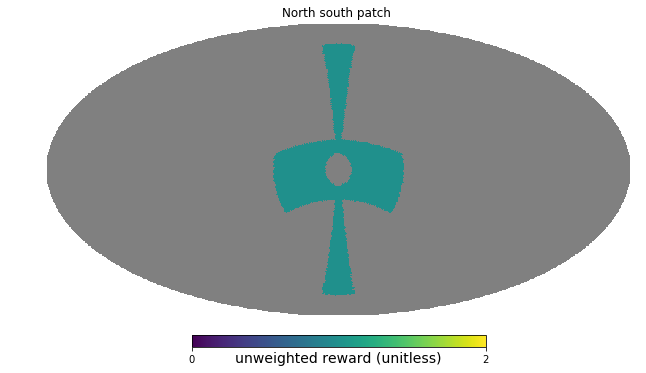

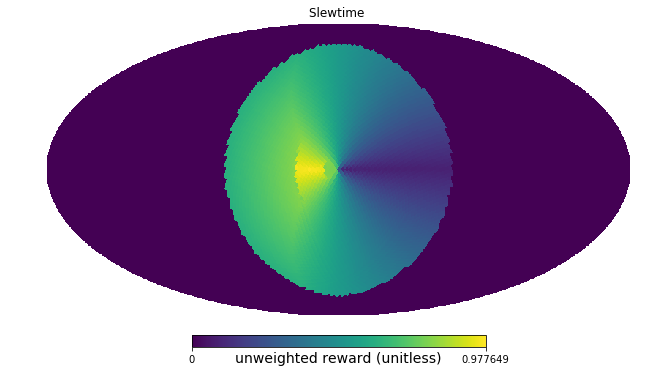

In [7]:
for bf in scheduler.surveys[0].basis_functions:
    val = bf()
    if np.size(val) == 1:
        print(val)
    else:
        if np.min(val) < 0:
            plotmin = 0
        else:
            plotmin = None
        hp.mollview(val, rot=(r1,r2), title=bf.__class__.__name__.replace('basis_function', '').replace('_', ' '),
                   unit='unweighted reward (unitless)')

In [8]:
scheduler.surveys[0].basis_functions[0].__class__.__name__.replace('basis_function', '').replace('_', ' ')

'M5 diff '

In [9]:
scheduler.surveys[0].basis_functions[1].survey_features['N_obs_count_all'].feature

670

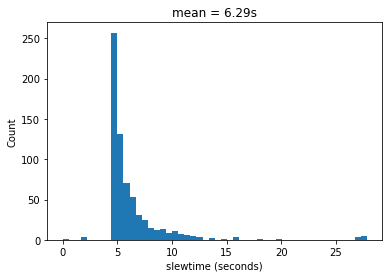

In [10]:
none = plt.hist(observations['slewtime'], bins=50)
plt.xlabel('slewtime (seconds)')
plt.ylabel('Count')
plt.title('mean = %.2fs' % np.mean(observations['slewtime']))

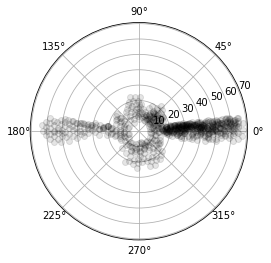

In [11]:
ax = plt.subplot(111, projection='polar')
ax.plot(np.radians(observations['az']), 90.-observations['alt'], 'ko', alpha=.1)

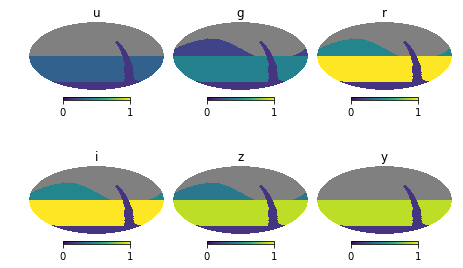

In [12]:
target_map = fs.standard_goals()
for i,key in enumerate(target_map):
    target_map[key][np.where(target_map[key] == 0)] = hp.UNSEEN
    hp.mollview(target_map[key], title=key, min=0, max=1,sub=(2,3, i+1))
plt.savefig('Plots/target_maps.pdf')

In [13]:
target_map[key]

array([ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30, ...,
         1.50000000e-01,   1.50000000e-01,   1.50000000e-01])

array([ 59579.03472222,  59588.36805555])

In [18]:
mjds = np.arange(59580, 59588.1, 0.05)
sun_alts = []
moon_alts = []
for mjd in mjds:
    info = sm.returnSunMoon(mjd)
    sun_alts.append(np.degrees(info['sunAlt']))
    moon_alts.append(np.degrees(info['moonAlt']))

In [19]:
good = np.where((np.array(sun_alts) < -18.) & (np.array(moon_alts) > 0.))

In [20]:
good

(array([102, 122, 142, 143]),)

In [21]:
mjds[122]

59586.100000000355

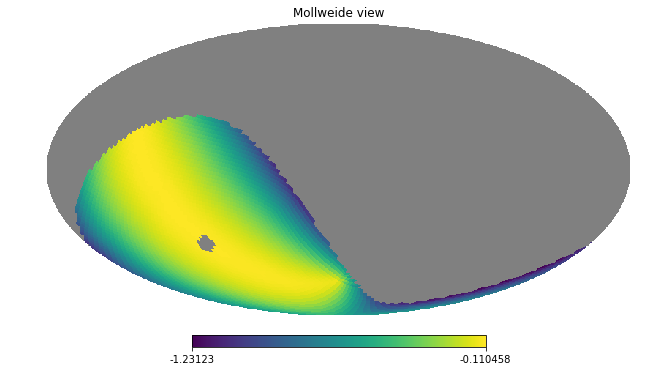

In [23]:
hp.mollview(scheduler.surveys[0].basis_functions[0](), rot=(r1,r2))